In [1]:
## Standard imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
import json
import torch
import astroddpm
import tqdm.notebook as tqdm

## Relative imports
from astroddpm.runners import Diffuser, config_from_id
from astroddpm.analysis.validationMetrics import powerSpectrum, minkowskiFunctional, basics
from astroddpm.analysis import overfitting_check
from astroddpm.utils.plot import check_nearest_epoch, plot_losses, check_training_samples, plot_comparaison
from astroddpm.diffusion.dm import ContinuousSBM, DiscreteSBM
from astroddpm.diffusion.stochastic.sde import DiscreteVPSDE
from astroddpm.diffusion.stochastic.solver import get_schedule
from astroddpm.diffusion.models.network import ResUNet, FFResUNet
from astroddpm.moment.models import SigmaMomentModel, SigmaMomentNetwork
from astroddpm.diffusion.stochastic.solver import power_law_schedule, linear_schedule

from diffusion import ExactScoreNetwork, ExactContinuousSBM, ExactContinuousVPSDE
#from astroddpm.diffusion.power_spectra.powerspec_sampler import CMB_H_OMBH2
from cmb_ps import CMBPS
from utils import unnormalize_phi, normalize_phi, sample_prior_phi, log_likelihood_eps_phi_sigma, get_phi_bounds

import astroddpm.utils.colormap_custom 

/mnt/sw/nix/store/pvz51gzx2lyqpabf08xhd1y2kvw5rfdy-python-3.9.16-view/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/mnt/sw/nix/store/d9jbiy4kghz72ak7mija92asihk8xcja-py-torchvision-0.15.2/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
MODEL_ID = 'ContinuousSBM_FFResUNet_bottleneck_32_firstc_10_beta_cosine_betamax_20_betamin_0.1'

In [4]:
config = config_from_id(MODEL_ID)
if 'FFResUNet' in MODEL_ID: ##Correct bug in the package
    print('FFResUNet')
    config['diffusion_model']['network']['type']='FFResUNet'
    config['diffusion_model']['network']['in_c']=1

FFResUNet


In [5]:
placeholder_dm = DiscreteSBM(DiscreteVPSDE(1000), ResUNet())
diffuser = Diffuser(placeholder_dm)
diffuser.load(config=config, also_ckpt=True, for_training=True)

No model id found
Loading the diffuser from a config dict.
{'in_c': 1, 'out_c': 1, 'first_c': 10, 'sizes': [256, 128, 64, 32], 'num_blocks': 1, 'n_steps': 1000, 'time_emb_dim': 100, 'dropout': 0, 'attention': [], 'normalisation': 'GN', 'padding_mode': 'circular', 'eps_norm': 1e-05, 'skiprescale': True, 'type': 'FFResUNet', 'discretization': 'continuous', 'embedding_mode': 'fourier', 'has_phi': False, 'phi_shape': None, 'phi_embed_dim': 100, 'n_ff_min': 6, 'n_ff_max': 8}
Loading the optimizer and scheduler states from the checkpoint, as well as previous training info. You should change the model id if you want to finetune the model.


In [6]:
diffusion_model_x = diffuser.diffmodel

In [7]:
## Matplotlib parameters
save_fig = False
## Carefull if not on the cluster
params = {'text.usetex': True,
         'text.latex.preamble': r'\usepackage{amsmath}',
         "font.family": "serif", "font.serif": ["Computer Modern Roman"],
         'font.size': 12,
         'image.interpolation': 'none'}
plt.rcParams.update(params)
amin = - 3
amax = 3

In [8]:
norm_phi_mode = 'compact'               # Normalization mode for phi among ['compact', 'inf', None]
phi_min, phi_max = get_phi_bounds()     # Bounds on phi (unnormalized)
phi_test = torch.tensor([70, 32.1e-3])  # True phi (unnormalized)
sigma_test = torch.tensor([0.2])        # True sigma

In [9]:
ps_model = CMBPS(norm_phi=norm_phi_mode).to(device) 
for parameter in ps_model.parameters():
    parameter.requires_grad = False

In [10]:
## Original image

batch = next(iter(diffuser.test_dataloader))
image = batch.unsqueeze(1).to(device)[:1]
image.shape

torch.Size([1, 1, 256, 256])

In [11]:
## Parameters for the Gibbs sampler and noise level/timestep
NUM_PARTICLES = 100
NOISE_LEVEL = sigma_test.item()
nparams = 1 ## 2 for phi
##Closest time step to the noise level requested
TIME_STEP = diffuser.diffmodel.sde.get_closest_timestep(torch.tensor(NOISE_LEVEL))
TIME_STEP = TIME_STEP.to(device)
print(f"Target time step chosen for noise level {NOISE_LEVEL}: {TIME_STEP.item()}")

Target time step chosen for noise level 0.20000000298023224: 0.11891306936740875


In [12]:
## Target cosmological parameters (and rescaled version)

phi_test_norm = normalize_phi(phi_test[:2], mode=norm_phi_mode).to(device)
print("Normalized test phi:", phi_test_norm)
ps_test = ps_model(phi_test_norm)
sq_ps_test = torch.sqrt(ps_test).to(device)

## Convert to float32
sq_ps_test = sq_ps_test.to(torch.float32)
sq_ps_test.shape

Normalized test phi: tensor([0.5000, 0.5000], device='cuda:0')


torch.Size([1, 256, 256])

In [13]:
## Artificial superposition of CMB and dust map

noisy, mean, noise = diffuser.diffmodel.sde.sampling(image, TIME_STEP, sq_ps_test)
noisy.shape, mean.shape, noise.shape

(torch.Size([1, 1, 256, 256]),
 torch.Size([1, 1, 256, 256]),
 torch.Size([1, 1, 256, 256]))

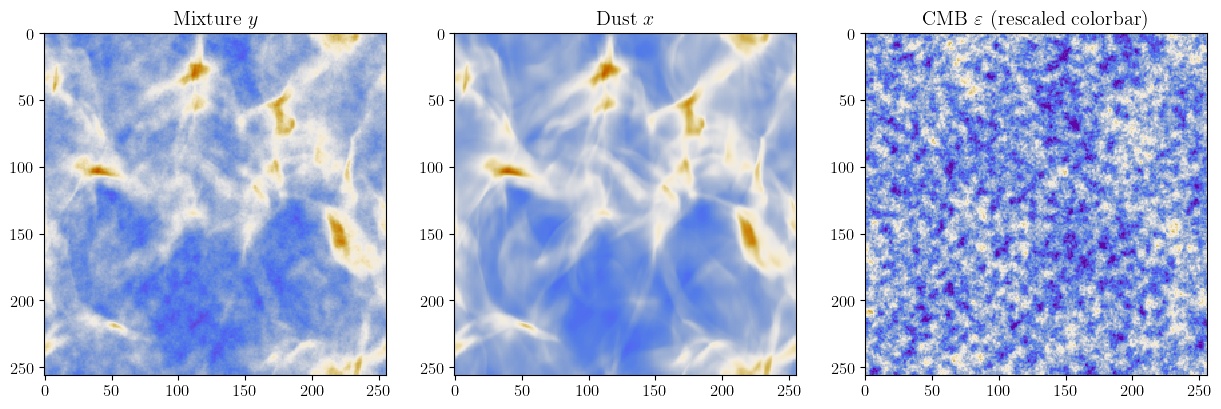

In [14]:
## Plot the noisy image (superposition) along with the noise (CMB/added gaussian components) and baseline (Dust/original image)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(noisy[0,0].cpu().numpy(), cmap='cmb', vmin=-3, vmax=6)
ax[0].set_title('Mixture $y$')
ax[1].imshow(image[0, 0].cpu().numpy(), cmap='cmb', vmin=-3, vmax=6)
ax[1].set_title('Dust $x$')
ax[2].imshow(noise[0, 0].cpu().numpy(), cmap='cmb', vmin=-3, vmax=6)
ax[2].set_title(r'CMB $\varepsilon$ (rescaled colorbar)')
#plt.savefig('inference_mixture_{:.2f}.pdf'.format(NOISE_LEVEL), bbox_inches='tight')
plt.show()

In [15]:
beta_min = diffusion_model_x.sde.beta_0
beta_max = diffusion_model_x.sde.beta_T
t_min = diffusion_model_x.sde.tmin
t_max = diffusion_model_x.sde.tmax
beta_schedule = diffusion_model_x.sde.beta_schedule

In [16]:
centers = torch.tensor([0.5, 0.5]).to(device).view(1, 2)
stds = torch.tensor([1/7, 1/7]).to(device).view(1, 2)
weights = torch.tensor([1.]).to(device)
score_net_phi = ExactScoreNetwork(centers, stds, weights, beta_min =beta_min , beta_max = beta_max, t_min = t_min, t_max = t_max, beta_schedule = beta_schedule)
score_net_phi = score_net_phi.to(device)

phi_sde = ExactContinuousVPSDE(beta_min =beta_min , beta_max = beta_max, t_min = t_min, t_max = t_max, beta_schedule = beta_schedule)
diffusion_model_phi = ExactContinuousSBM(phi_sde, score_net_phi)

In [17]:
## Check the prior on phi
num_samples = 80

prior_samples_phi = sample_prior_phi(num_samples).to(device)

t = torch.ones(num_samples).to(device)*t_max
tmin = torch.ones(num_samples).to(device)*t_min
schedule = power_law_schedule(t_min = tmin, t_max = t, n_iter = 1000, power = 2)
#generative_prior_samples = diffusion_model_phi.generate_image(num_samples, schedule=schedule)

In [18]:
def forward_log_likelihood(x,phi,y,rescaling_factor=torch.zeros(1)):
    epsilon = y - x
    sigma_2 = sigma_test.to(device).reshape(1)**2+rescaling_factor.reshape(-1)
    log_likelihood = log_likelihood_eps_phi_sigma(phi, epsilon, sigma_2, ps_model)
    return log_likelihood

def forward_log_likelihood_phi(x,phi,y,rescaling_factor=torch.zeros(1)):
    epsilon = y - x
    sigma_2 = sigma_test.to(device).reshape(1)**2+rescaling_factor.reshape(-1)
    eps_dim = eps.shape[-1]*eps.shape[-2]
    ps = ps_model(phi)
    xf = torch.fft.fft2(eps)

In [19]:
## A twisted diffusion sampler to solve the blind inverse problem

def twisted_diffusion_sampler_blind(diffusion_model_x, diffusion_model_phi, sample_size, observation, 
                              forward_log_likelihood,
                              schedule, 
                              eta = 1,
                              threshold_resampling = 0.9, return_auxiliary = False, verbose=True, eta_phi =1e-3):
    """
    Twisted diffusion sampler for solving the blind inverse problem.
    diffuion_model: a diffusion model with a 'network' and an SDE
    sample_size: number of particles
    observation: the observation y
    forward_log_likelihood: a function that takes x, phi, y, rescaling_factor (opt) and returns the log-likelihood of y given x and phi
    log_prior_phi: a function that takes phi and returns the log-prior of phi
    sample_prior_phi: a function that samples from the prior of phi
    schedule: a schedule object
    eta: the exploration rescaling factor in the diffusion
    phi_temperature_rescaling: if True, the temperature rescaling is applied to the guidance term for phi
    threshold_resampling: the threshold for the effective sample size under which resampling is triggered
    return_auxiliary: if True, the function returns the effective sample size, the memory of the samples and the rescaling factors
    verbose: if True, a progress bar is displayed
    """
    times = schedule.flip(1)
    diffusion_model_x.network.eval()
    diffusion_model_phi.network.eval()
    for param in diffusion_model_x.network.parameters():
        param.requires_grad = False
    for param in diffusion_model_phi.network.parameters():
        param.requires_grad = False
    in_c_x = diffusion_model_x.network.in_c
    shape_x = diffusion_model_x.network.sizes[0]
    ndim_phi = diffusion_model_phi.network.ndim
    # Initialization
    x_t = diffusion_model_x.sde.prior_sampling((sample_size, in_c_x, shape_x, shape_x)).to(device)
    phi_t = diffusion_model_phi.sde.prior_sampling((sample_size, ndim_phi)).to(device)
    x_t.requires_grad_(True)
    phi_t.requires_grad_(True)
    t = times[:,0].to(device).unsqueeze(1)
    # Precompute some terms for loop initialization
    model_output_x = diffusion_model_x.network(x_t, t)
    model_output_phi = diffusion_model_phi.network(phi_t, t)
    x_hat_0 = diffusion_model_x.sde.tweedie_reverse(x_t, t, model_output_x)
    phi_hat_0 = diffusion_model_phi.sde.tweedie_reverse(phi_t, t, model_output_phi)
    Beta_t = diffusion_model_x.sde.Beta(t).reshape(-1)
    rescaling = torch.sqrt(1 - torch.exp(-Beta_t)).reshape(-1)
    
    g = forward_log_likelihood(x_hat_0, phi_hat_0, observation, rescaling**2/eta)
    guidance = torch.autograd.grad(-g.sum(), [x_t, phi_t], create_graph=True)
    guidance_x = guidance[0]
    guidance_phi = guidance[1]
    # First set of weights
    log_p_obs_given_x_t_phi_t = g
    log_weights = log_p_obs_given_x_t_phi_t

    # Loop parameters and variables
    nsteps = times.shape[1]-1
    progress_bar = tqdm.tqdm(total=nsteps, disable = not verbose)
    memory_every = nsteps//7
    memory_samples = []
    ratio=[]
    ess_list = []

    for i in range(nsteps):
        with torch.no_grad():  
            # Weights computation 
            weights = torch.softmax(log_weights, dim=0)
            ess = 1/(weights**2).sum().item()
            ess_list.append(ess)
            # Resampling
            if ess < sample_size*threshold_resampling:
                idx = torch.multinomial(weights, sample_size, replacement=True)
                x_t = x_t[idx]
                phi_t = phi_t[idx]
                guidance_x = guidance_x[idx]
                guidance_phi = guidance_phi[idx]
                model_output_x = model_output_x[idx]
                model_output_phi = model_output_phi[idx]
                log_p_obs_given_x_t_phi_t = log_p_obs_given_x_t_phi_t[idx]
                log_weights = torch.zeros_like(log_weights)
            if i%memory_every == 0:
                memory_samples.append((x_t.cpu().detach().numpy(), phi_t.cpu().detach().numpy()))

            # Time step
            t_1 = times[:,i+1].to(device).unsqueeze(1)
            dt = t_1 - t

            # Compute the drift and diffusion terms
            ## Unconditional drift and diffusion (i.e. without guidance)
            unconditional_drift_x, unconditional_diffusion_x = diffusion_model_x.sde.reverse(x_t, t, model_output_x)
            unconditional_drift_phi, unconditional_diffusion_phi = diffusion_model_phi.sde.reverse(phi_t, t, model_output_phi)
            ## Conditional drift (i.e. with guidance)
            Beta_t = diffusion_model_x.sde.Beta(t).reshape(-1, 1)
            rescaling = torch.sqrt(1 - torch.exp(-Beta_t)).reshape(-1)*(i!=nsteps-1)
            conditionnal_drift_x, _ = diffusion_model_x.sde.reverse(x_t, t, model_output_x + 1e-6*guidance_x*rescaling.reshape(-1, 1, 1, 1))
            conditionnal_drift_phi, _ = diffusion_model_phi.sde.reverse(phi_t, t, model_output_phi + eta_phi*guidance_phi*rescaling.reshape(-1, 1))

            # Diffuse the particles + compute different log-likelihood terms
            ## Diffusion
            beta_t = diffusion_model_x.sde.beta(t).reshape(-1)
            std_diffusion = torch.sqrt(torch.abs(dt).reshape(-1)*beta_t)
            #print(x_t.shape, conditionnal_drift_x.shape, dt.shape, unconditional_diffusion_x.shape, torch.sqrt(torch.abs(dt)).reshape(-1, 1, 1, 1).shape)
            x_t_1 = x_t + conditionnal_drift_x*dt.reshape(-1,1,1,1) + unconditional_diffusion_x*torch.sqrt(torch.abs(dt)).reshape(-1, 1, 1, 1)
            phi_t_1 = phi_t + conditionnal_drift_phi*dt + unconditional_diffusion_phi*torch.sqrt(torch.abs(dt))
            ## Log-likelihood terms
            log_p_x_t_1_given_x_t = -torch.sum((x_t_1 - (x_t + unconditional_drift_x*dt.reshape(-1, 1, 1, 1)))**2, dim =[-1, -2, -3])/(2*std_diffusion**2) #- torch.log(std_diffusion)*ndim
            log_p_x_t_1_given_x_t_guidance = -torch.sum((x_t_1 - (x_t + conditionnal_drift_x*dt.reshape(-1, 1, 1, 1)))**2, dim = [-1, -2, -3])/(2*std_diffusion**2)# - torch.log(std_diffusion)*ndim
            log_p_phi_t_1_given_phi_t = -torch.sum((phi_t_1 - (phi_t + unconditional_drift_phi*dt))**2, dim = 1)/(2*std_diffusion**2) #- torch.log(std_diffusion)*ndim
            log_p_phi_t_1_given_phi_t_guidance = -torch.sum((phi_t_1 - (phi_t + conditionnal_drift_phi*dt))**2, dim = 1)/(2*std_diffusion**2) #- torch.log(std_diffusion)*ndim
        
            ## Updates
            x_t = x_t_1.detach()
            phi_t = phi_t_1.detach()
        x_t.requires_grad_(True)
        phi_t.requires_grad_(True)
        phi_t = torch.ones_like(phi_t)*1/2

        ## Next step computations
        model_output_x = diffusion_model_x.network(x_t, t_1)
        x_hat_0 = diffusion_model_x.sde.tweedie_reverse(x_t, t_1, model_output_x)
        model_output_phi = diffusion_model_phi.network(phi_t, t_1)
        phi_hat_0 = diffusion_model_phi.sde.tweedie_reverse(phi_t, t_1, model_output_phi)
        Beta_t_1 = diffusion_model_x.sde.Beta(t_1).reshape(-1)
        rescaling = torch.sqrt(1 - torch.exp(-Beta_t_1)).reshape(-1)

        g = forward_log_likelihood(x_hat_0, phi_hat_0, observation, rescaling**2/eta)
        guidance_x, guidance_phi = torch.autograd.grad(-g.sum(), [x_t, phi_t], create_graph=True)
        guidance_phi = torch.zeros_like(guidance_phi)
        with torch.no_grad():
            log_p_obs_given_x_t_1_phi_t_1 = g

            if i==nsteps-1:
                #log_p_obs_given_x_t_1_phi_t_1 = forward_log_likelihood(x_t, phi_t, observation, torch.zeros_like(rescaling))
                log_p_obs_given_x_t_1_phi_t_1 = forward_log_likelihood(x_hat_0, phi_hat_0, observation, torch.zeros_like(rescaling))
            
            log_weights+=log_p_phi_t_1_given_phi_t-log_p_phi_t_1_given_phi_t_guidance
            log_weights+=log_p_x_t_1_given_x_t-log_p_x_t_1_given_x_t_guidance
            log_weights+=log_p_obs_given_x_t_1_phi_t_1-log_p_obs_given_x_t_phi_t

            log_p_obs_given_x_t_phi_t = log_p_obs_given_x_t_1_phi_t_1
            t = t_1
            ratio.append(rescaling[0].item()**2/eta/sigma_test.item()**2)
            progress_bar.update(1)
        if i%100==0:
            fig, ax = plt.subplots(1, 1, figsize=(5, 5))
            ax.imshow(x_hat_0[0,0].detach().cpu().numpy(), cmap='cmb', vmin=-3, vmax=6)
            print(g)
    progress_bar.close()
    weights = torch.softmax(log_weights, dim=0)
    ess_list.append(1/(weights**2).sum().item())
    idx = torch.multinomial(weights, sample_size, replacement=True)
    if return_auxiliary:
        return x_t[idx], phi_t[idx], ess_list, memory_samples, ratio
    return x_t[idx], phi_t[idx]

  0%|          | 0/999 [00:00<?, ?it/s]

tensor([-5430939.9595, -5490627.2012, -5498079.5636, -5485127.8653,
        -5432196.5660, -5545670.1054, -5463492.7371, -5693734.7055,
        -5478931.7960, -5534755.9550, -5456495.7400, -5421400.2025,
        -5482901.1401, -5690913.1461, -5400927.2023, -5456942.9032,
        -5390550.9136, -5502213.1025, -5417414.7317, -5488520.0879,
        -5389836.7233, -5423194.5896, -5421640.7962, -5454116.8037,
        -5623073.5886, -6001396.3419, -5464843.1027, -5344611.9106,
        -5482654.5354, -5408610.2383, -5498607.1636, -5491306.1188,
        -5406660.9645, -5430378.4971, -5407272.5376, -5446456.3169,
        -5623420.7372, -5471744.5587, -5454993.1424, -5429619.9611,
        -5432072.6487, -5493457.6156, -5338368.2554, -5410104.5395,
        -5412337.8190, -5394594.0880, -5762463.2414, -5533480.2930,
        -5464598.7676, -5416345.0739, -5573406.7663, -5630607.6620,
        -5629708.7818, -5371496.6388, -5391290.9124, -5427750.5982,
        -5433872.1237, -5381854.5009, -5463881.4

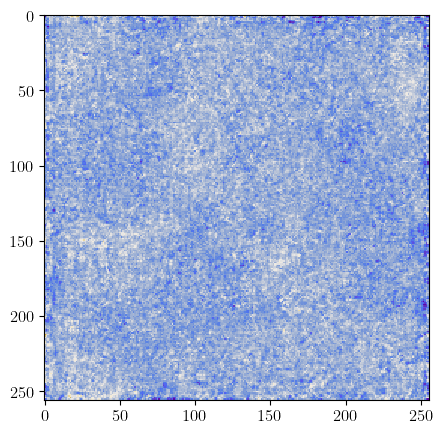

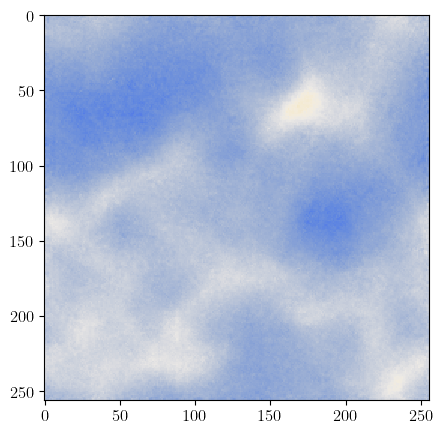

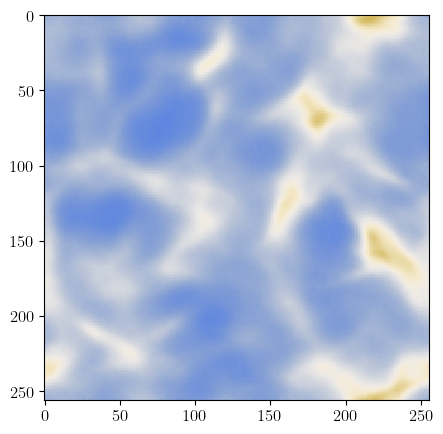

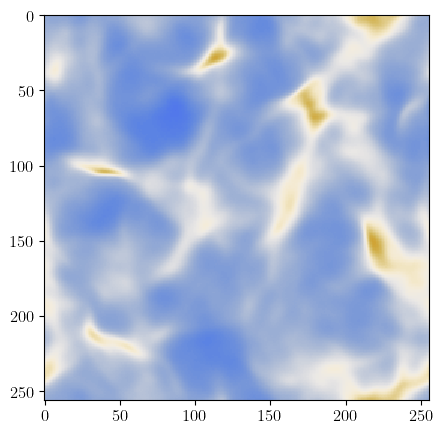

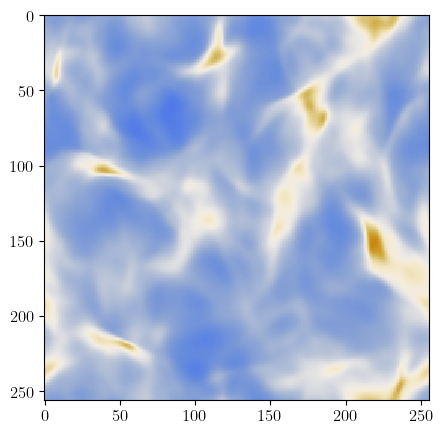

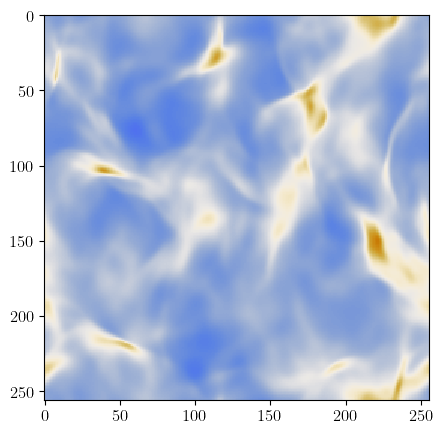

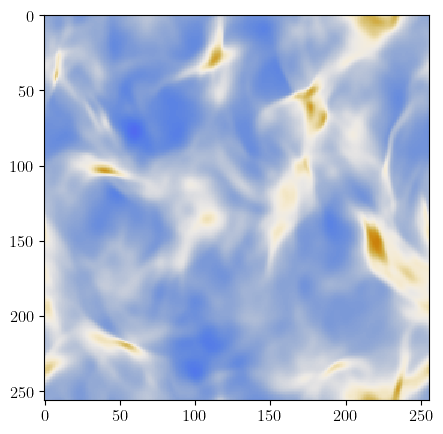

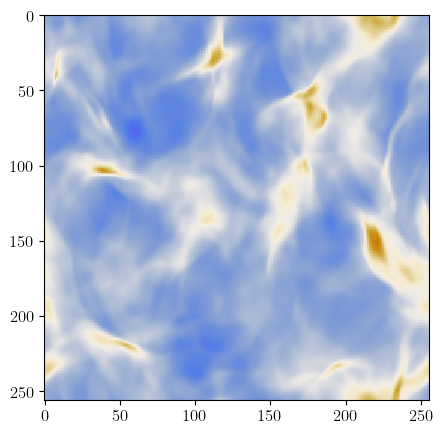

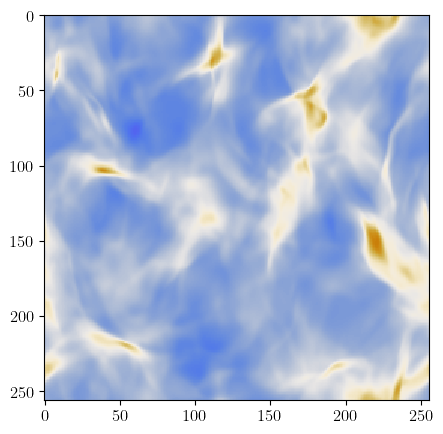

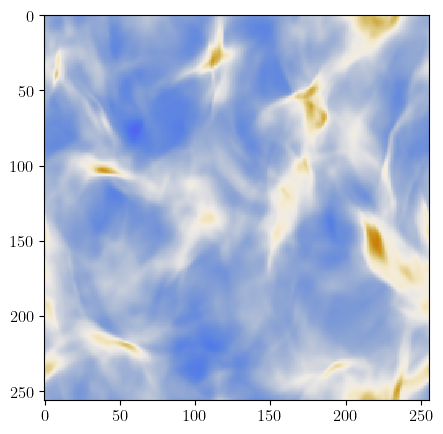

In [20]:
x, phi,ess_list, memory_samples, ratio = twisted_diffusion_sampler_blind(diffusion_model_x, diffusion_model_phi, num_samples, noisy, forward_log_likelihood, schedule, eta = 1, threshold_resampling=0.9, return_auxiliary=True, verbose=True)

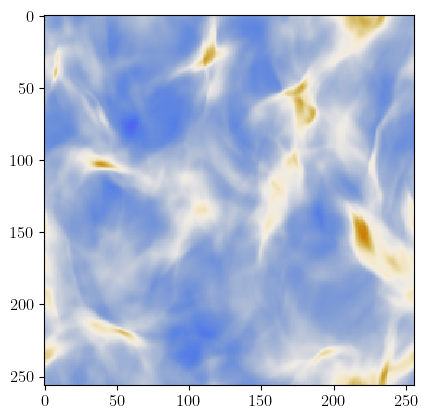

In [21]:
plt.imshow(x[0,0].detach().cpu().numpy(), cmap='cmb', vmin=-3, vmax=6)

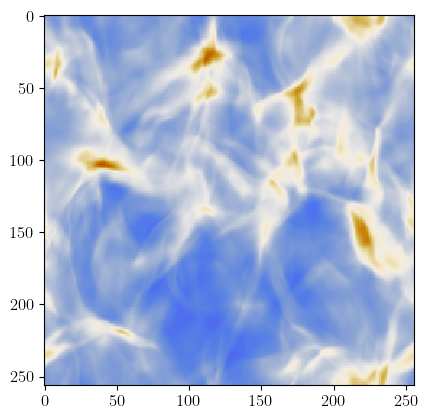

In [22]:
plt.imshow(image[0,0].cpu().numpy(), cmap='cmb', vmin=-3, vmax=6)

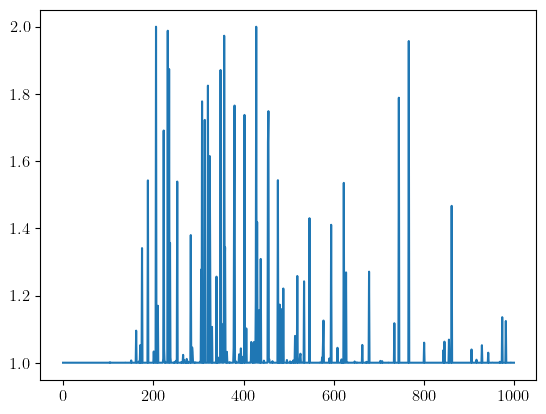

In [23]:
plt.plot(ess_list)